In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
true = pd.read_csv('/content/gdrive/My Drive/dataset/True.csv')
fake = pd.read_csv('/content/gdrive/My Drive/dataset/Fake.csv')

In [4]:
fake.shape

(23481, 4)

In [5]:
true.shape

(21417, 4)

**Data cleaning and preparation**

In [6]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [7]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape


(44898, 5)

In [8]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [9]:
# Check the data
data.head()

,title,text,subject,date,target
0,"ACTRESS ACCUSES Weinstein Buddy, Actor GEORGE ...","The Hill During a recent interview, Clooney ...",left-news,"Oct 13, 2017",fake
1,Senators introduce bill aimed at getting gener...,WASHINGTON (Reuters) - Four U.S. senators - tw...,politicsNews,"June 14, 2016",true
2,LIBERAL AMERICAN STUDENT Gets Brutal Lesson In...,Irish journalist and documentary filmmaker Ann...,left-news,"May 3, 2017",fake
3,Britain says Iran's treatment of jailed aid wo...,LONDON (Reuters) - Iran s continued detention ...,worldnews,"November 7, 2017",true
4,Democratic donor contacts Biden allies about p...,NEW YORK (Reuters) - A prominent Democratic do...,politicsNews,"February 6, 2016",true


In [10]:
# Removing the date 
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,"ACTRESS ACCUSES Weinstein Buddy, Actor GEORGE ...","The Hill During a recent interview, Clooney ...",left-news,fake
1,Senators introduce bill aimed at getting gener...,WASHINGTON (Reuters) - Four U.S. senators - tw...,politicsNews,true
2,LIBERAL AMERICAN STUDENT Gets Brutal Lesson In...,Irish journalist and documentary filmmaker Ann...,left-news,fake
3,Britain says Iran's treatment of jailed aid wo...,LONDON (Reuters) - Iran s continued detention ...,worldnews,true
4,Democratic donor contacts Biden allies about p...,NEW YORK (Reuters) - A prominent Democratic do...,politicsNews,true


In [11]:
# Removing the title 
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,"The Hill During a recent interview, Clooney ...",left-news,fake
1,WASHINGTON (Reuters) - Four U.S. senators - tw...,politicsNews,true
2,Irish journalist and documentary filmmaker Ann...,left-news,fake
3,LONDON (Reuters) - Iran s continued detention ...,worldnews,true
4,NEW YORK (Reuters) - A prominent Democratic do...,politicsNews,true


In [12]:
# Convert to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,"the hill during a recent interview, clooney ...",left-news,fake
1,washington (reuters) - four u.s. senators - tw...,politicsNews,true
2,irish journalist and documentary filmmaker ann...,left-news,fake
3,london (reuters) - iran s continued detention ...,worldnews,true
4,new york (reuters) - a prominent democratic do...,politicsNews,true


In [13]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [14]:
# Check
data.head()

,text,subject,target
0,the hill during a recent interview clooney d...,left-news,fake
1,washington reuters four us senators two demo...,politicsNews,true
2,irish journalist and documentary filmmaker ann...,left-news,fake
3,london reuters iran s continued detention of ...,worldnews,true
4,new york reuters a prominent democratic donor...,politicsNews,true


In [15]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
data.head()

,text,subject,target
0,hill recent interview clooney describes conser...,left-news,fake
1,washington reuters four us senators two democr...,politicsNews,true
2,irish journalist documentary filmmaker ann mce...,left-news,fake
3,london reuters iran continued detention jailed...,worldnews,true
4,new york reuters prominent democratic donor wo...,politicsNews,true


**Basic Data Exploration**

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


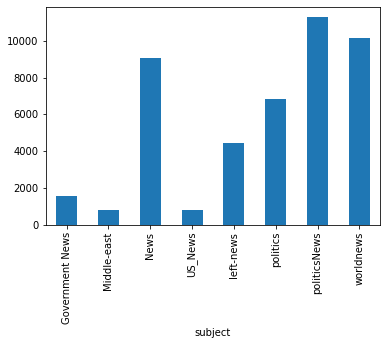

In [17]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


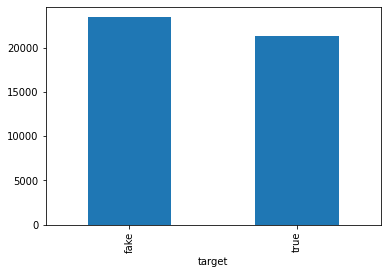

In [18]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

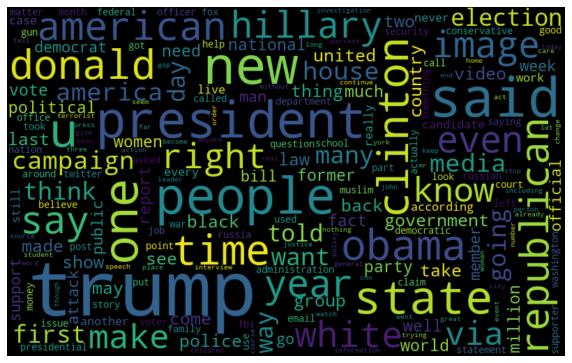

In [19]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

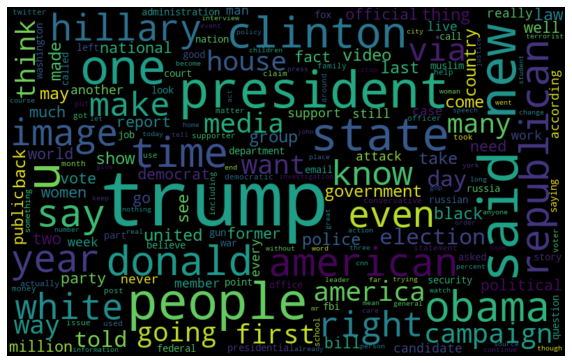

In [20]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
# Most frequent words counter    
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

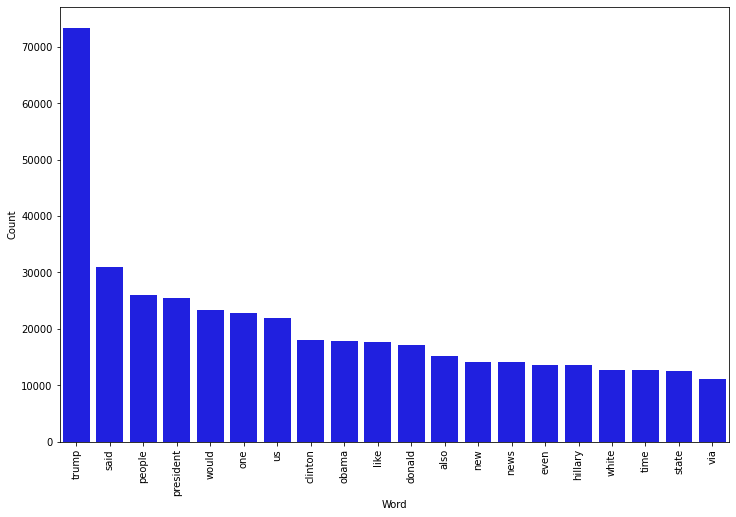

In [22]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

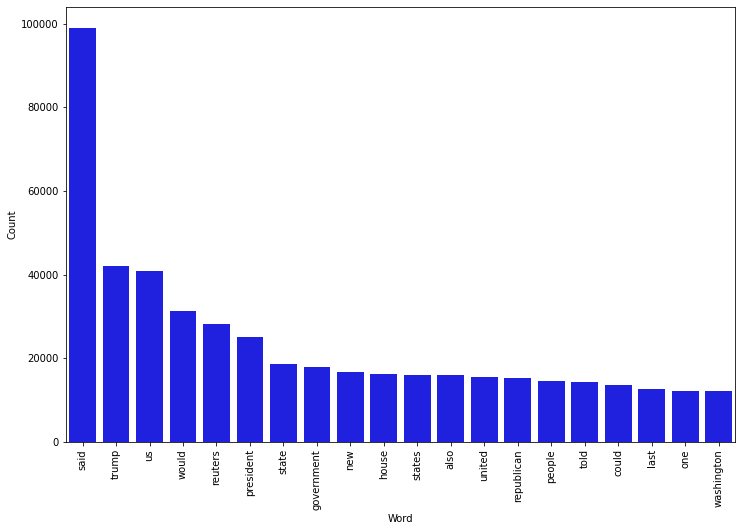

In [23]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

**Modeling**

In [24]:
# Function to plot the confusion matrix
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Preparing the Data**

In [25]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

**Logistic Regression**

In [26]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.11%


Confusion matrix, without normalization


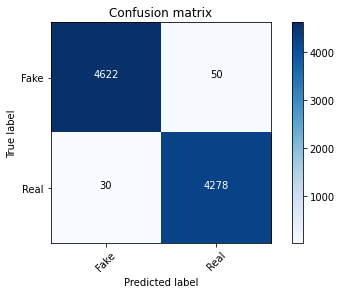

In [27]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

**Decision Tree Classifier**

In [28]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))


accuracy: 99.55%


Confusion matrix, without normalization


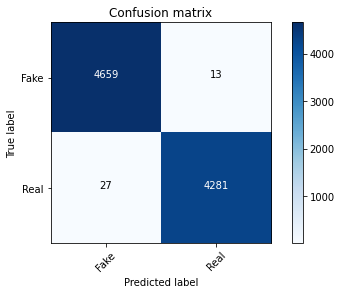

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

**Random Forest Classifier**

In [30]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.24%


Confusion matrix, without normalization


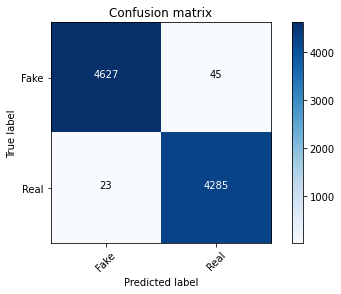

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

**Naive Bayes**

In [32]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 95.39%


Confusion matrix, without normalization


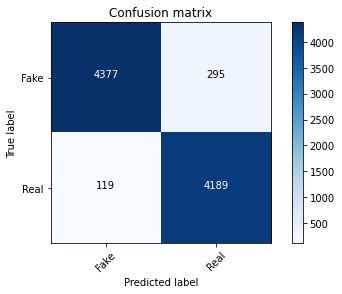

In [33]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

**SVM**

In [34]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.57%


Confusion matrix, without normalization


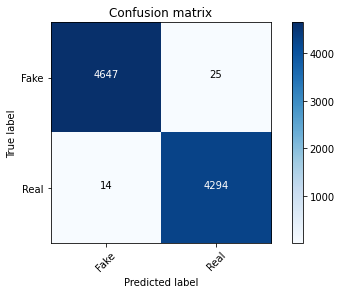

In [35]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

**Comparing Different Models**

(0.9, 1.0)

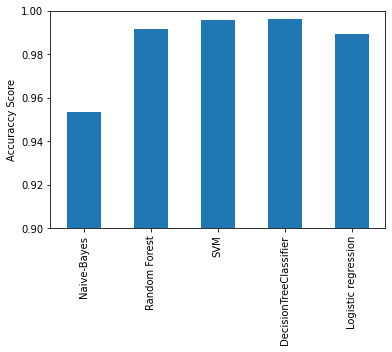

In [36]:
model_accuracy={
    'Naive-Bayes': 0.9537 , 'Random Forest':0.9918 , 'SVM' : 0.9957 , 'DecisionTreeClassifier' : 0.9964 , 'Logistic regression': 0.9893 
}
pd.Series(model_accuracy).plot(kind='bar')
plt.ylabel('Accuraccy Score')
plt.ylim((0.90, 1.0))